In [21]:
# Author: Anne Sabourin
# Description: DAMEX/CLEF tutorial: comparison

# Comparison between CLEF and DAMEX.
"""

This notebook demonstrates a typical scenario where DAMEX frequently
identifies numerous 'false' subfaces in high-dimensional settings, or
no non-trivial subface at all (here, by trivial subface, we mean
either a singleton subface, or the largest subface including all
features), even when a reasonable `min_counts` threshold is applied to
disregard small subfaces.

This propensity for false discovery is further exacerbated in
adversarial settings (controlled by the `add_noisy_feature` Boolean
variable), where a random feature is introduced to each extreme sample
point.

In contrast, CLEF generally identifies fewer subfaces that are more
closely aligned with the 'true' subfaces.

From a quantitative standpoint, DAMEX sometimes outperforms CLEF in terms
of deviance.

In summary, while DAMEX's output may be less interpretable and
convenient for subsequent analysis—a primary motivation for the
development of CLEF— DAMEX may still outperform CLEF in terms of
'distance to truth,' which can be interpreted as predictive
performance.

In higher dimensions (d~50) , the output if DAMEX is highly sensitive
to the choice of `min_counts' in DAMEX typically fails to recover
meaningful subfaces. CLEF on the contrary is more stable.

**References:**

[1] Goix, N., Sabourin, A., & Clémençon, S. (2017). Sparse
representation of multivariate extremes with applications to anomaly
detection. Journal of Multivariate Analysis, 161, 12-31.

[2] Chiapino, M., & Sabourin, A. (2016). Feature clustering for
extreme events analysis, with application to extreme stream-flow
data. In *International Workshop on New Frontiers in Mining Complex
Patterns* (pp. 132-147). Cham: Springer International Publishing.

[3] Chiapino, M., Sabourin, A., & Segers, J. (2019). Identifying
groups of variables with the potential of being large
simultaneously. *Extremes, 22*, 193-222.

"""

In [22]:
# # Set working directory if necessary
import os
os.getcwd()
# #os.chdir("../")

'/home/anne/Dropbox/RECHERCHE/CODE/MLExtreme'

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pprint as pp
import MLExtreme as mlx

# Define the norm function as the infinite norm (other norms are not
# implemented in DAMEX / CLEF). This definition is not required for
# running CLEF/DAMEX and is used here solely for visualization and
# analysis of the output.


def norm_func(x):
    return np.max(x, axis=1)

## Ground truth definition:
Define or generate a list of subfaces of the unit sphere that
represent the support of the limit measure.

In [24]:
Plot = False
seed = 42
dim = 50  # try  50, 100
num_subfaces = 10  # try 5, 20, 50
subfaces_list = mlx.gen_subfaces(dimension=dim,
                                 num_subfaces=num_subfaces,
                                 max_size=10,  # try 4, 10, 20
                                 prevent_inclusions=True,
                                 seed=seed)

# # Uncomment for a simpler example:
# subfaces_list = [[0, 1], [1, 2], [2, 3, 4]]

if False:   # change to True to print the list of subfaces
    print(subfaces_list)
    pp.pprint(mlx.list_to_dict_size(subfaces_list))

subfaces_matrix = mlx.subfaces_list_to_matrix(subfaces_list, dim)
#print(subfaces_matrix)

# Dimension, number of mixture components,
# weights and Dirichlet center locations
n = int(np.sqrt(dim) * 10**3)
k = np.shape(subfaces_matrix)[0]
dim = np.shape(subfaces_matrix)[1]
# Define admissible Dirichlet mixture parameters for the limit angular measure
# of a marginally Pareto-standardized heavy-tailed vector,
# based on the matrix of subfaces.
# This avoids potentially imbalanced settings across features.
wei = np.ones(k)/k
Mu, wei = mlx.normalize_param_dirimix(subfaces_matrix, wei)
# Print the subfaces and their weights, and record them as a list
# for further use.
faces_true = subfaces_list
wei_true = wei
print(f'Mu matrix: \n {np.round(Mu, 3)}')
print(f'Weights: {np.round(wei, 3)}')

Mu matrix: 
 [[0.    0.143 0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.154 0.    0.   ]
 [0.    0.111 0.333 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]]
Weights: [0.047 0.13  0.06  0.087 0.03  0.02  0.027 0.107 0.067 0.087 0.02  0.02
 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02
 0.02  0.02  0.02 ]


### Difficulty Settings for the Tail Problem

The `lnu` parameter below is the logarithm of the concentration
parameter for the Dirichlet mixture. It is a crucial parameter that
determines the difficulty of the clustering problem. If any
$\exp(\text{lnu}[i]) \times \text{Mu}[i,j] < 1$, the problem is
pathologically hard, as the mass on any subface concentrates on the
boundary of that face. Conversely, if all $\exp(\text{lnu}[i]) \times
\text{Mu}[i,j] \gg 1$, the problem is very easy.

Experiment with the 'difficulty' parameter below, which should be
strictly positive. Values greater than one correspond to very hard
problems, while values close to zero generate very easy
problems. Interesting results occur for difficulty $\approx 0.8$.

In [25]:
difficulty = 0.8

min_mus = np.zeros(k)
for j in range(k):
    min_mus[j] = np.min(Mu[j, Mu[j, :] > 0])
lnu = np.log(1/(difficulty**2) * 1/min_mus)
# check (change to True  to display)
if False:
    print("absolute dirichlet parameters: ")
    print(Mu * np.exp(lnu).reshape(-1, 1))

 Other parameter settings that govern the speed of convergence of
the conditional distribution above a radial threshold towards the
limit measure.  

In [26]:
# Regular variation index of the data
alpha = 2

# Centers of mass of the Dirichlet mixture in the bulk (vanishing
# impact above large radial thresholds):
Mu_bulk = np.ones((k, dim))/dim

 `index_weight_noise` below indicates how fast the impact of noise decreases
with large radial thresholds. Specifically, the noise's weight decreases as:
$(C/\text{radius})^{\text{index\_weight\_noise}}$

In [27]:
index_weight_noise = 4

### Dataset Generation and Visualisation

In [28]:
# Generate data
np.random.seed(42)
X = mlx.gen_rv_dirimix(alpha, np.round(Mu, 3),  wei, lnu,
                       scale_weight_noise=1, Mu_bulk=Mu_bulk,
                       index_weight_noise=index_weight_noise, size=n)

Add a Noisy 'Large' Feature to Each Sample Point.

To simulate an adversarial setting, add a noisy 'large' feature to
each sample point. Set the option to `False` for comparison purposes.

In [29]:
add_noisy_feature = True
if add_noisy_feature:
    n = np.shape(X)[0]
    dim = np.shape(X)[1]
    for i in range(n):
        jmax = np.argmax(X[i,])
        j_noise =  np.argmin(X[i,])##np.random.randint(dim-1)
        if j_noise == jmax:
            j_noise = dim-1
        X[i, j_noise] = X[i, jmax]

# Define rank-transformed data
Xt = mlx.rank_transform(X)

# Generate test data for unsupervised evaluation (without noise)
np.random.seed(12345)
Xtest = mlx.gen_rv_dirimix(alpha, np.round(Mu, 3),  wei, lnu,
                           scale_weight_noise=1, Mu_bulk=Mu_bulk,
                           index_weight_noise=index_weight_noise, size=5*n)

# Define rank-transformed test data
std_Xtest = mlx.rank_transform(Xtest)

In [30]:
# Pairwise plot of generated data for two dependent components
len_faces = np.sum(subfaces_matrix, axis=1)
r_i = np.where(len_faces > 1)[0][0]
iplot = subfaces_list[r_i][0]
jplot = subfaces_list[r_i][1]

if Plot:
    plt.figure(figsize=(10, 10))
    X_disp = X**(alpha/4)  # for easier visualization only
    max_val = np.max(X_disp)
    scatter = plt.scatter(X_disp[:, iplot], X_disp[:, jplot], alpha=0.5)
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature d')
    plt.title('Scatter Plot of the raw  dataset')
    plt.show()

In [31]:
# rank transformed  generated data with unit Pareto margins
# and visualization
if Plot:
    plt.figure(figsize=(10, 10))
    X_disp = Xt**(1/4)  # for easier visualization only
    max_val = np.max(X_disp)
    scatter = plt.scatter(X_disp[:, iplot], X_disp[:, jplot], alpha=0.5)
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature d')
    plt.title('Scatter Plot of the  rank transformed dataset')
    plt.show()

# Data Analysis
## Radial threshold selection before model fitting

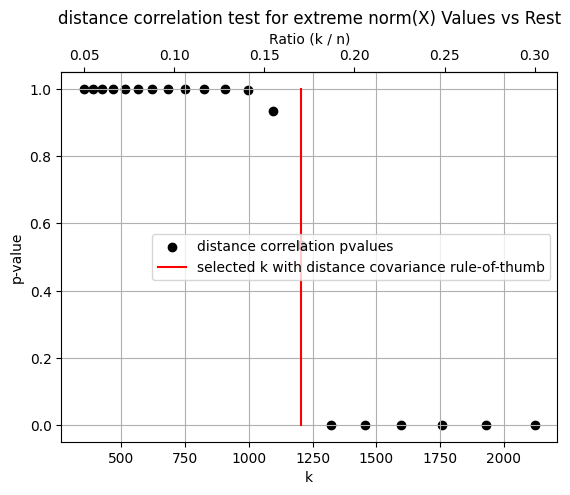

maximum ratio of extreme samples from rule-of-thumb distance covariance test: 0.17


In [32]:
# Select the radial threshold via distance-covariance tests.
# See the tutorials on classification and regression for more details.
ntests_thresh = 20
ratio_ext = np.geomspace(0.05, 0.3, num=ntests_thresh)
pval, ratio_max = mlx.test_indep_radius_rest(Xt, y=None, ratio_ext=ratio_ext,
                                             norm_func=norm_func)

if True:
    mlx.plot_indep_radius_rest(pval, ratio_ext, ratio_max, n)

print(f'maximum ratio of extreme samples from rule-of-thumb \
distance covariance test: {mlx.round_signif(ratio_max, 2)}')
ratio_extremes = ratio_max * 4/5 
norm_Xt = norm_func(Xt)
# Radial threshold selected with rule-of-thumb radius-versus-rest
# independence tests:
threshold = np.quantile(norm_Xt, 1 - ratio_extremes)
# Note: The following is not 'k' in the notations of Goix et al. [1]
# Instead, it is between k and d * k. It is the number of data points
# above the radial threshold.
number_extremes = np.sum(norm_Xt >= threshold)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%

##  DAMEX  clustering  (Goix et al, [1] )

DAMEX: selected epsilon with AIC criterion 0.001


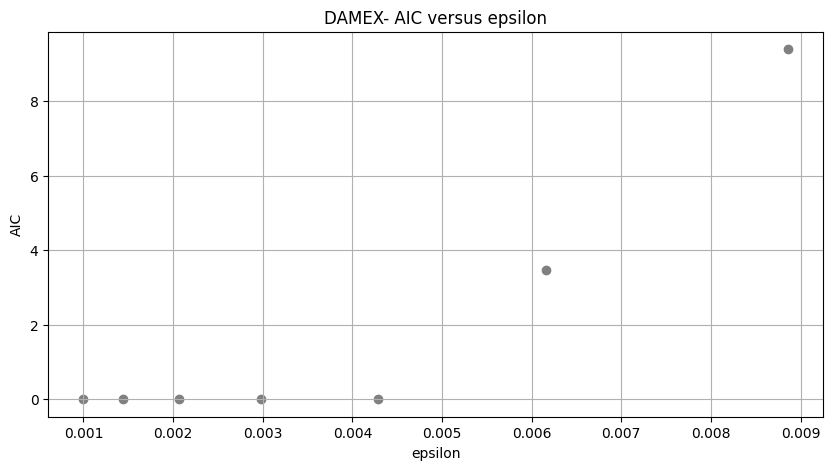

DAMEX: selected epsilon with CV criterion 0.001


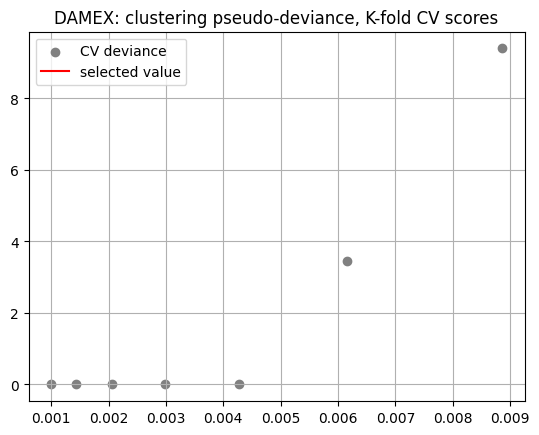

deviance truth to damex aic:
17.519191919191922
deviance truth to damex cv:
17.519191919191922


In [33]:
# Explore setting `inlude_singletons` to True
include_singletons = False

# Explore other settings: 0,2, 10, np.sqrt(number_extremes)
min_counts = 5
rate = 10

damex_clust = mlx.damex(min_counts=min_counts,
                        thresh_train=threshold, thresh_test=threshold,
                        include_singletons=include_singletons,
                        rate=rate)

ntests = 20
vect_eps = np.geomspace(10**(-3), 1, num=ntests)

eps_select_aic, damex_aic_opt, damex_aic_values = \
    damex_clust.select_epsilon_AIC(
        vect_eps, Xt, standardize=False, plot=True, update_epsilon=False)

eps_select_cv, damex_cv_opt, damex_cv_values = damex_clust.select_epsilon_CV(
    vect_eps, Xt, standardize=False, plot=True, update_epsilon=False)


damex_clust.fit(Xt, epsilon=eps_select_aic, standardize=False)
_, damex_aic_dev_to_true = damex_clust.deviance_to_true(faces_true, wei_true)


damex_clust.fit(Xt, epsilon=eps_select_cv, standardize=False)
_, damex_cv_dev_to_true = damex_clust.deviance_to_true(faces_true, wei_true)

# # %%
# # In view of the plots above, it seems reasonable to set kappa_min
# # to the first value above which aic/cv deviance is not constant, ~0.015
# # explore this option by  un-commenting  the following:

# eps_select_visual = 0.005
# damex_clust.fit(Xt, epsilon=eps_select_visual, standardize=False)
# _, damex_visual_dev_to_true = damex_clust.deviance_to_true(faces_true, wei_true)

print('deviance truth to damex aic:')
print(damex_aic_dev_to_true)

print('deviance truth to damex cv:')
print(damex_cv_dev_to_true)

# print('deviance truth to damex with epsilon set from visual inspection:')
# print(damex_visual_dev_to_true)

# ############

## CLEF Clustering (Chiapino et al., [2,3]

CLEF: selected kappa_min with AIC criterion: 0.0014


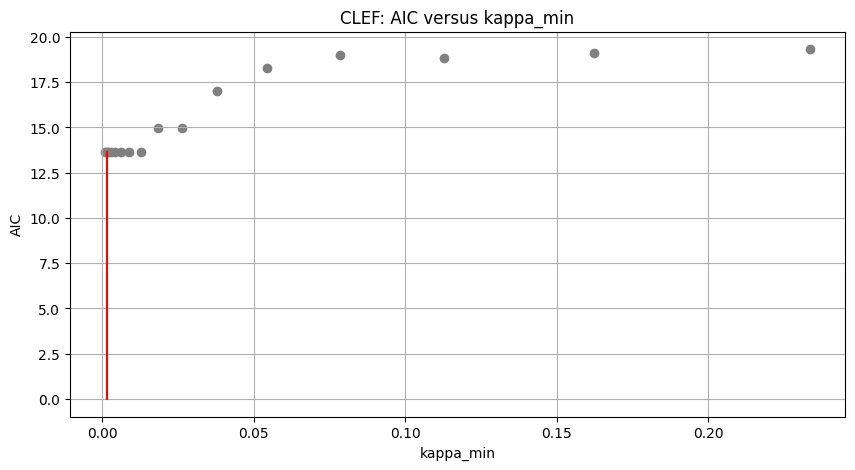

CLEF: selected kappa_min with CV estimate of deviance: 0.0014


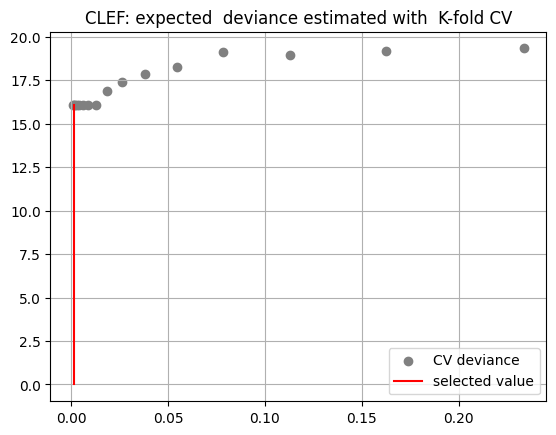

In [34]:
clef_clust = mlx.clef(thresh_train=threshold, thresh_test=threshold,
                      rate=rate)

ntests = 20
vect_kappa = np.geomspace(10**(-3), 1, num=ntests)
kappa_select_aic, clef_aic_opt, clef_aic_values = \
    clef_clust.select_kappa_min_AIC(
        vect_kappa, Xt, standardize=False, unstable_kappam_max=0.01,
        plot=True, update_kappa_min=False)

kappa_select_cv, clef_cv_opt, clef_cv_values = clef_clust.select_kappa_min_CV(
    vect_kappa, Xt, standardize=False,  unstable_tol_max=0.01,
    plot=True, update_kappa_min=False, random_state=1)

In [35]:

clef_clust.fit(Xt, kappa_min=kappa_select_aic, standardize=False)
_, clef_aic_dev_to_true = clef_clust.deviance_to_true(faces_true, wei_true)

clef_clust.fit(Xt, kappa_min=kappa_select_cv*20, standardize=False)
_, clef_cv_dev_to_true = clef_clust.deviance_to_true(faces_true, wei_true)


# # In view of the plots above, it it may seem reasonable to set kappa_min
# # to the first value above which aic/cv deviance is not constant, ~0.015
#  Uncomment below to implement this option

# clef_clust.fit(Xt, kappa_min=0.015, standardize=False)
# _, clef_visual_dev_to_true = clef_clust.deviance_to_true(faces_true, wei_true)

#pp.pprint(mlx.list_to_dict(clef_clust.subfaces, clef_clust.masses))

print('deviance truth to clef aic:')
print(clef_aic_dev_to_true)

print('deviance truth to clef cv:')
print(clef_cv_dev_to_true)

print("number of subfaces found by DAMEX:")
print(len(damex_clust.subfaces))
print("number of subfaces found by CLEF:")
print(len(clef_clust.subfaces))
print("approximate number of true subfaces:")
print(num_subfaces)

deviance truth to clef aic:
15.44065714094646
deviance truth to clef cv:
18.742921333178803
number of subfaces found by DAMEX:
1
number of subfaces found by CLEF:
46
approximate number of true subfaces:
10


## Qualititative comparison:

In [36]:
# Inspect all subfaces. To hide, set to False below
if True:
    print("damex subfaces")
    damex_cv_faces, damex_cv_masses = mlx.list_to_dict(damex_clust.subfaces,
                                                       damex_clust.masses)
    pp.pprint(damex_cv_faces)

    print("clef subfaces")
    clef_cv_faces, clef_cv_masses = mlx.list_to_dict(clef_clust.subfaces,
                                                     clef_clust.masses)
    pp.pprint(clef_cv_faces)

    print("true subfaces")
    true_faces, _ = mlx.list_to_dict(faces_true,
                                     wei_true)
    pp.pprint(true_faces)

damex subfaces
{1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: [],
 12: [],
 13: [],
 14: [],
 15: [],
 16: [],
 17: [],
 18: [],
 19: [],
 20: [],
 21: [],
 22: [],
 23: [],
 24: [],
 25: [],
 26: [],
 27: [],
 28: [],
 29: [],
 30: [],
 31: [],
 32: [],
 33: [],
 34: [],
 35: [],
 36: [],
 37: [],
 38: [],
 39: [],
 40: [],
 41: [],
 42: [],
 43: [],
 44: [],
 45: [],
 46: [],
 47: [],
 48: [],
 49: [],
 50: [[0,
       1,
       2,
       3,
       4,
       5,
       6,
       7,
       8,
       9,
       10,
       11,
       12,
       13,
       14,
       15,
       16,
       17,
       18,
       19,
       20,
       21,
       22,
       23,
       24,
       25,
       26,
       27,
       28,
       29,
       30,
       31,
       32,
       33,
       34,
       35,
       36,
       37,
       38,
       39,
       40,
       41,
       42,
       43,
       44,
       45,
       46,
       47,
       48,
       49]]}
clef subfac

**General Observations**

In general, DAMEX tends to recover either the highest-dimensional
subfaces exclusively or only singleton subfaces. It is also very sensitive to the choice of `min_counts`. In contrast, CLEF
produces more stable results, including moderate-dimensional subfaces
that are reasonably close to the true subfaces.  